<img src="../fasp/runner/credits/images/FullHouse.png" style="float: right;">

## Accessing SRA Controlled Access data
This notebook explores using GA4GH DRS to access data stored in the cloud for a controlled access dbGaP project - [phs001554](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id=phs001554.v1.p1) "Detection of Colorectal Cancer Susceptibility Loci Using Genome-Wide Sequencing".

A query using the GA4GH Search API on controlled access subject and file attributes identifies DRS ids. 

>Note: The subject and sample data searched through the initial query are on a scrambled copy of the data so that no controlled access records remain intact. Please do not attempt to draw meaningful associations between the subject and sample attributes with the genomic data; this would lead to erroneous conclusions. These examples serve only to illustrate future possibilities, in the hope of identifying ways to make those possibilities real.
>
>The sequence files used in this notebook are also under controlled access. You will not be able to access those files unless you have been granted access through dbGaP to the phs001554 study. If you have that access you will also have access to the non-scrambled subject and sample data. If that is the case, we would be pleased to hear of your interest, and the possibility of collaborating to ensure the GA4GH tools described here enable your studies. Please see [form to register interest](https://docs.google.com/forms/d/e/1FAIpQLSfmmc3VKd6ANdzaVMyelT3c9gIWuoS4ZwT0vsqD-o2ZRxJf7A/viewform)

In [1]:
from fasp.search import DataConnectClient
from fasp.loc import crdcDRSClient
from fasp.workflow import sbcgcWESClient
from fasp.runner import FASPRunner

faspRunner = FASPRunner()
runNote = 'GECCO files retrieved from Gen3 DRS and computed on SB'

searchClient = DataConnectClient('https://ga4gh-search-adapter-presto-public.prod.dnastack.com/')
query = '''select acc, sa.sample_id, drs_id, sex, age
from search_cloud.cshcodeathon.gecco_gen3_drs_index i
join dbgap_demo.scr_gecco_susceptibility.sample_multi sa on sa.sample_id = i.sample_id
join dbgap_demo.scr_gecco_susceptibility.subject_phenotypes_multi su on su.dbgap_subject_id = sa.dbgap_subject_id
where age between 50 and 55
and affection_status = 'Case'
and file_type = 'cram' limit 3'''
df = searchClient.runQuery(query, returnType='dataframe')
df

Running GECCO_Gen3_on_SB.ipynb
_Retrieving the query_
____Page1_______________
____Page2_______________
____Page3_______________
____Page4_______________
____Page5_______________
____Page6_______________


,acc,sample_id,drs_id,sex,age
0,SRR7271762,117454,dg.4DFC/89c68e80-0f5b-47de-b01b-8eb789a1061b,Male,54
1,SRR7271780,117477,dg.4DFC/fea9649e-1750-43c3-9b87-b314219eb840,Female,55
2,SRR7271789,117486,dg.4DFC/8ff3df8b-671e-42e3-a684-0dfa49c20e35,Male,55


In [2]:
drsClient = crdcDRSClient('/Users/forei/.keys/crdc_credentials.json', 's3')

settings = faspRunner.settings
wesClient = sbcgcWESClient(settings['SevenBridgesProject'])

faspRunner.configure(searchClient, drsClient, wesClient)

query = '''select acc, drs_id
from search_cloud.cshcodeathon.gecco_gen3_drs_index i
join dbgap_demo.scr_gecco_susceptibility.sample_multi sa on sa.sample_id = i.sample_id
join dbgap_demo.scr_gecco_susceptibility.subject_phenotypes_multi su on su.dbgap_subject_id = sa.dbgap_subject_id
where age between 50 and 55
and affection_status = 'Case'
and file_type = 'cram' limit 3'''


run_ids = faspRunner.runQuery(query, runNote)
import pandas as pd
runs_df = pd.DataFrame(run_ids)
runs_df

Running query
select acc, drs_id
from search_cloud.cshcodeathon.gecco_gen3_drs_index i
join dbgap_demo.scr_gecco_susceptibility.sample_multi sa on sa.sample_id = i.sample_id
join dbgap_demo.scr_gecco_susceptibility.subject_phenotypes_multi su on su.dbgap_subject_id = sa.dbgap_subject_id
where age between 50 and 55
and affection_status = 'Case'
and file_type = 'cram' limit 3
_Retrieving the query_
____Page1_______________
____Page2_______________
____Page3_______________
____Page4_______________
____Page5_______________
____Page6_______________
subject=SRR7271762, drsID=dg.4DFC/89c68e80-0f5b-47de-b01b-8eb789a1061b
https://cgc-ga4gh-api.sbgenomics.com/ga4gh/wes/v1
workflow submitted, run:3f680012-5633-4b78-af92-334cb41004d1
____________________________________________________________
subject=SRR7271780, drsID=dg.4DFC/fea9649e-1750-43c3-9b87-b314219eb840
https://cgc-ga4gh-api.sbgenomics.com/ga4gh/wes/v1
workflow submitted, run:86fb0ebe-03de-4efb-80c2-d1b029bc583c
_________________________

,subject,run_id
0,SRR7271762,3f680012-5633-4b78-af92-334cb41004d1
1,SRR7271780,86fb0ebe-03de-4efb-80c2-d1b029bc583c
2,SRR7271789,9f55bf91-e25d-4bfb-9d5c-ae53f94c8451


In [3]:
merged_df = pd.merge(
    df,
    runs_df,
    how="inner",
    left_on='acc',
    right_on='subject'
)
merged_df.drop('subject', axis=1, inplace=True)
merged_df.drop('drs_id', axis=1, inplace=True)
merged_df.to_csv('~/mywork.csv')
merged_df

,acc,sample_id,sex,age,run_id
0,SRR7271762,117454,Male,54,3f680012-5633-4b78-af92-334cb41004d1
1,SRR7271780,117477,Female,55,86fb0ebe-03de-4efb-80c2-d1b029bc583c
2,SRR7271789,117486,Male,55,9f55bf91-e25d-4bfb-9d5c-ae53f94c8451


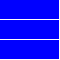

In [4]:
faspRunner.getFASPicon()

Update the dataframe with the status of the runs

In [14]:
for index, row in merged_df.iterrows():
    status = wesClient.getTaskStatus(row['run_id'])
    merged_df.at[index, "status"] = status
merged_df

,acc,sample_id,sex,age,run_id,status
0,SRR7271762,117454,Male,54,3f680012-5633-4b78-af92-334cb41004d1,COMPLETE
1,SRR7271780,117477,Female,55,86fb0ebe-03de-4efb-80c2-d1b029bc583c,COMPLETE
2,SRR7271789,117486,Male,55,9f55bf91-e25d-4bfb-9d5c-ae53f94c8451,COMPLETE


Once the runs have completed the results can be retrieved.

First two convenience functions are defined

In [15]:
import requests
import os
def download(url, file_path):
    with open(os.path.expanduser(file_path), "wb") as file:
        response = requests.get(url)
        file.write(response.content)
        
def getStats(filePath, statsList):
    ''' Extract values from a SAMTools Stats results file'''
    ### 
    
    retDict = {}
    f = open(filePath, "r")
    for x in f:
        if x.startswith('SN'):   
            parts = x.split('\t')
            statName = parts[1].split(':')[0]
            if statName in statsList:
                retDict[statName] = parts[2].rstrip()
    return retDict
        


In [16]:
from fasp.loc import DRSMetaResolver
mr = DRSMetaResolver()
statsList = []
for index, row in merged_df.iterrows():
    log = wesClient.GetRunLog(row['run_id'])
    resultsDRSID = log['outputs']['statistics']['path']
    url = mr.getAccessURL2(resultsDRSID,'s3')
    fileName = log['outputs']['statistics']['name']
    download(url, fileName)
    statsRequired = ['insert size average','insert size standard deviation']
    stats = getStats(fileName, statsRequired)
    stats['acc'] = row['acc']
    statsList.append(stats)
    os.remove(fileName)
stats_df =  pd.DataFrame(statsList)

Searching the GA4GH registry for org.ga4gh:drs services


In [17]:
stats_df

,insert size average,insert size standard deviation,acc
0,353.2,90.4,SRR7271762
1,346.4,84.8,SRR7271780
2,334.9,92.1,SRR7271789


In [18]:
final_df = pd.merge(
    merged_df,
    stats_df,
    how="inner",
    left_on='acc',
    right_on='acc'
)
final_df.drop('status', axis=1, inplace=True)
final_df.drop('run_id', axis=1, inplace=True)

final_df

,acc,sample_id,sex,age,insert size average,insert size standard deviation
0,SRR7271762,117454,Male,54,353.2,90.4
1,SRR7271780,117477,Female,55,346.4,84.8
2,SRR7271789,117486,Male,55,334.9,92.1
